# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [2]:
import os
import getpass

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

In [1]:
import networkx as nx
import matplotlib.pyplot as plt


We'll also want to set a project name to make things easier for ourselves.

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [4]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [5]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31287    0 31287    0     0   120k      0 --:--:-- --:--:-- --:--:--  121k


In [6]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70146    0 70146    0     0   600k      0 --:--:-- --:--:-- --:--:--  606k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [7]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [8]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [9]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [10]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

In [26]:
nodes = list(kg.nodes)[:2]  # Get first two nodes

print("Example of two nodes and their relationship:")
print(f"\nNode 1: {nodes[0]}")
print(f"Node 2: {nodes[1]}")

Example of two nodes and their relationship:

Node 1: Node(id: 216f6c, type: NodeType.DOCUMENT, properties: ['page_content', 'document_metadata', 'headlines', 'summary', 'summary_embedding'])
Node 2: Node(id: 84e5ee, type: NodeType.DOCUMENT, properties: ['page_content', 'document_metadata', 'headlines', 'summary', 'summary_embedding'])


Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [11]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 72)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 72)

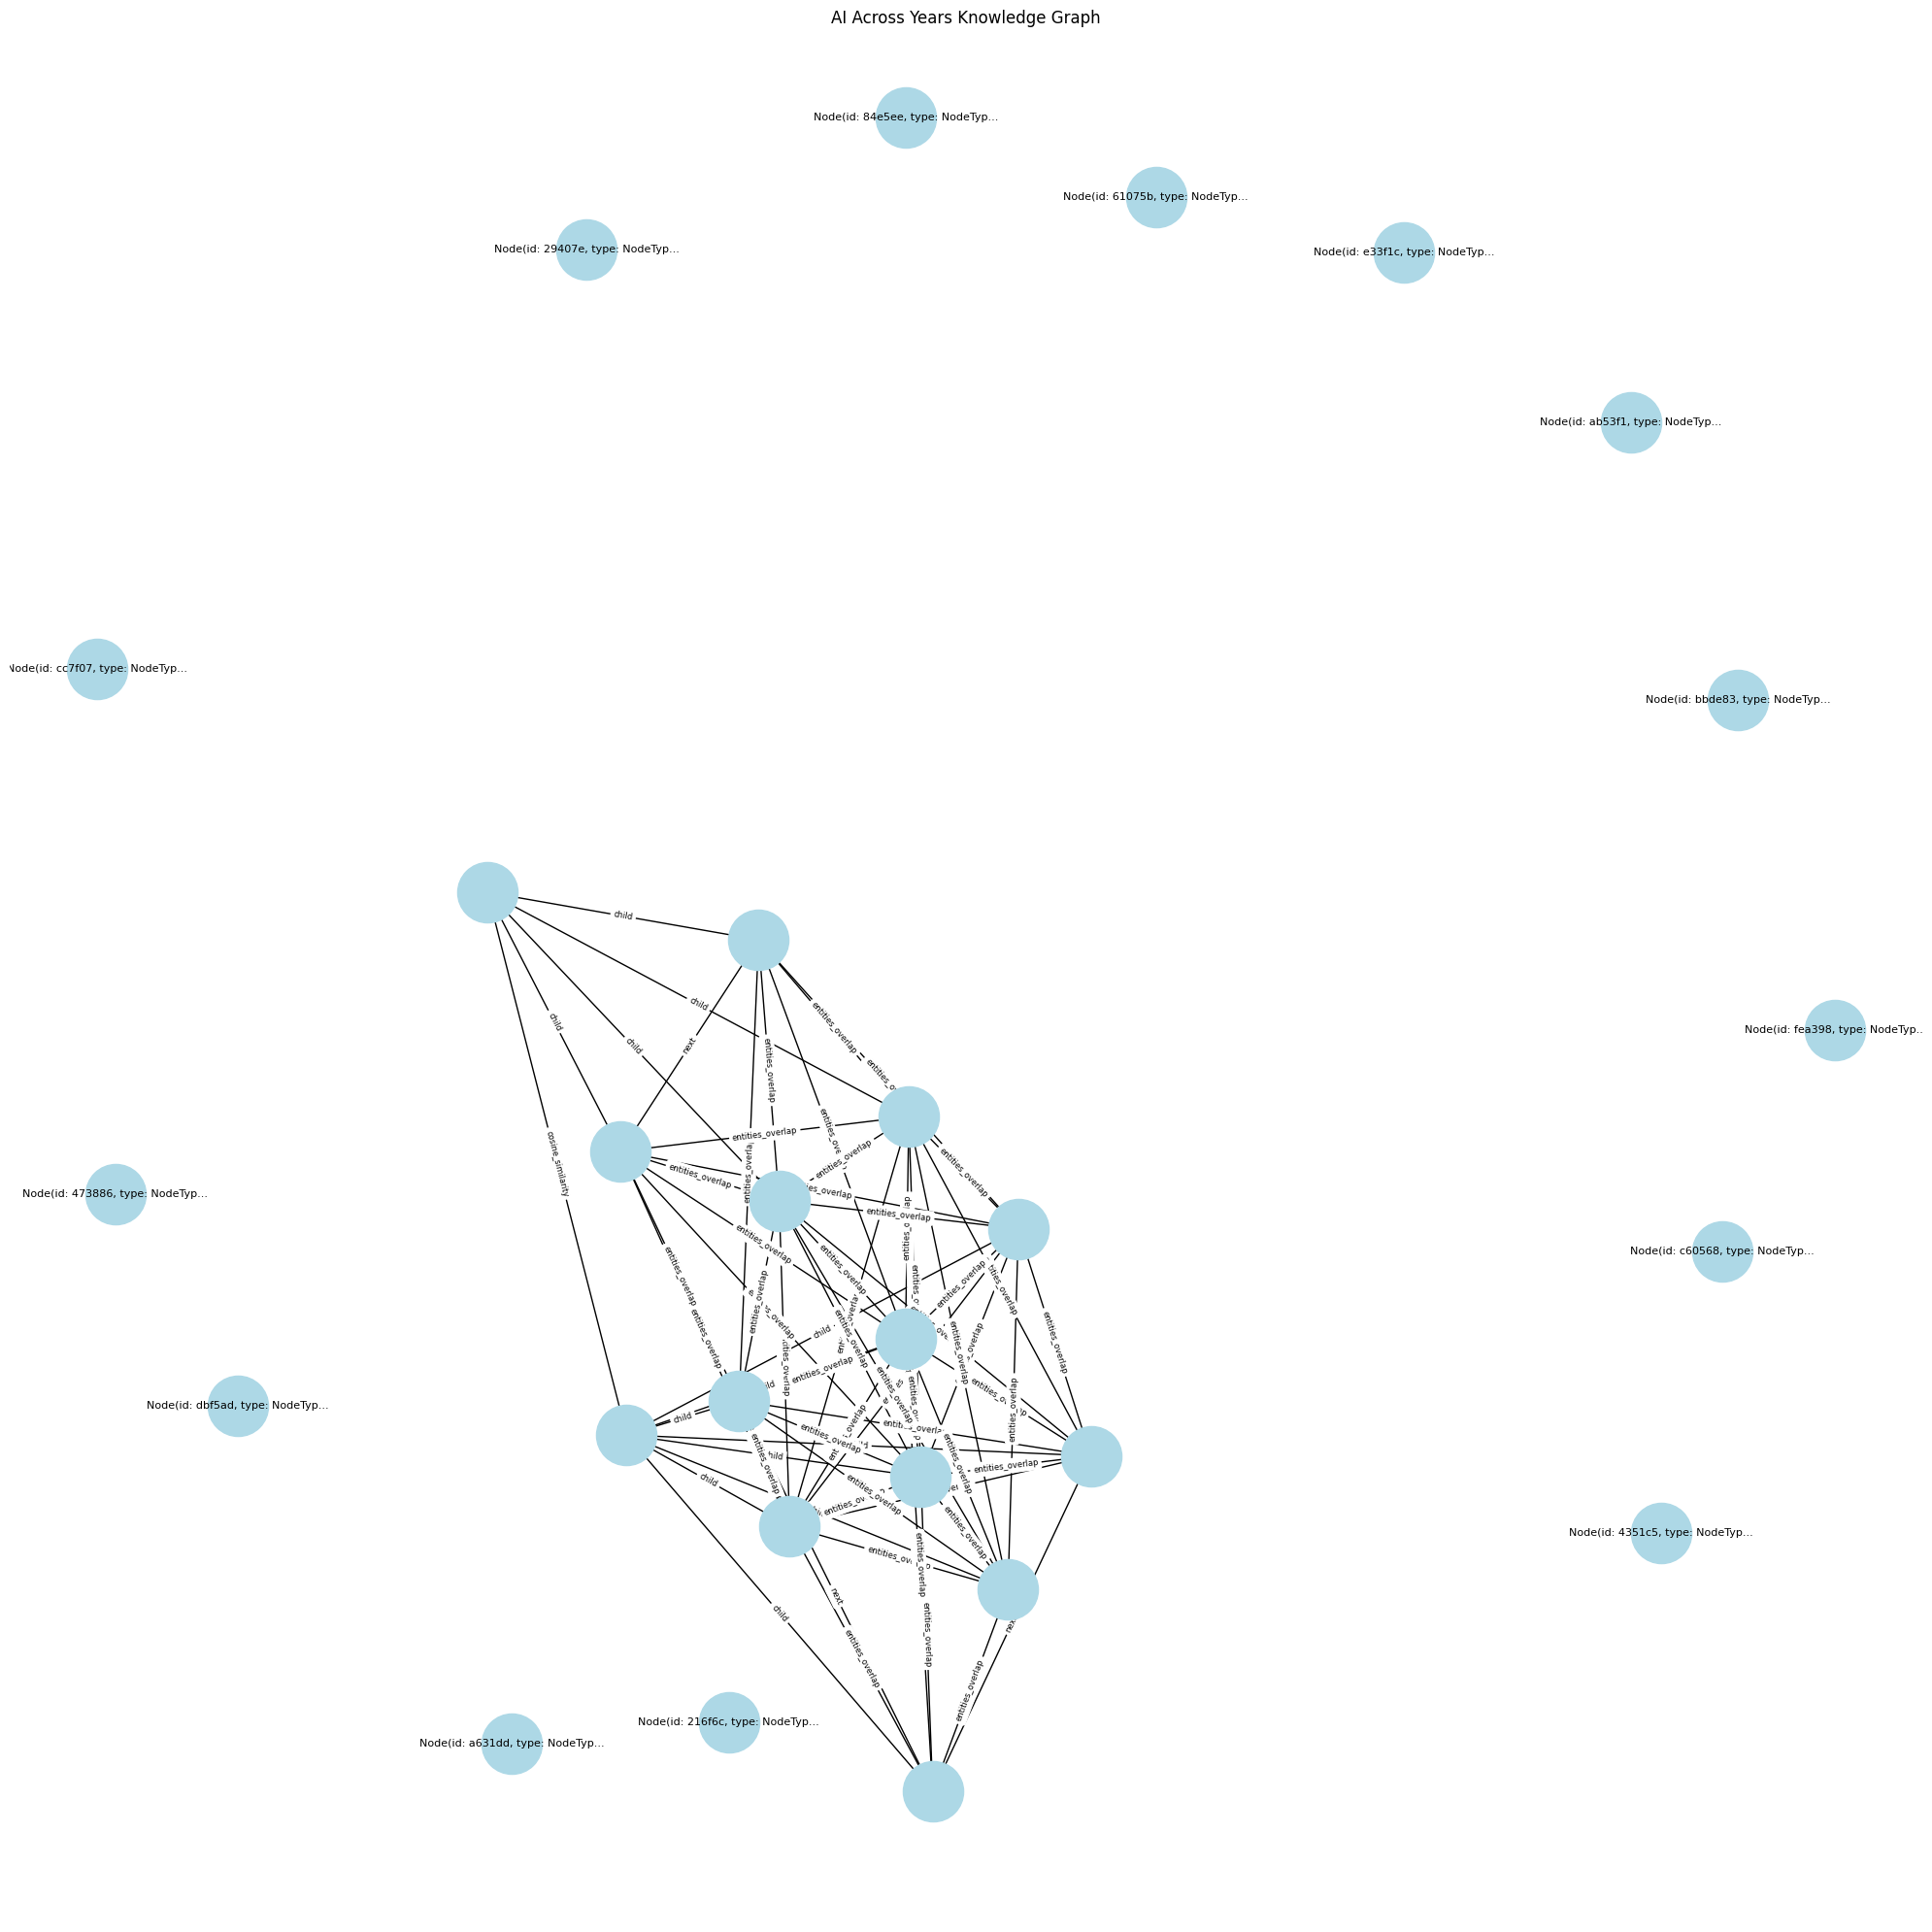

In [22]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a NetworkX graph from the knowledge graph
G = nx.Graph()

# Add nodes
for node in ai_across_years_kg.nodes:
    # Try to get a meaningful label from the node
    # Since we don't have text/content attribute, use str representation
    label = str(node)[:30] + "..." if len(str(node)) > 30 else str(node)
    G.add_node(node.id, label=label)

# Add edges/relationships 
for rel in ai_across_years_kg.relationships:
    G.add_edge(rel.source, rel.target, label=rel.type)

# Set up the plot
plt.figure(figsize=(20,20))

# Create the layout
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')

# Draw the edges
nx.draw_networkx_edges(G, pos)

# Add node labels
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=8)  # Removed wrap parameter

# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

plt.title("AI Across Years Knowledge Graph")
plt.axis('off')
plt.tight_layout()
plt.show()





In [27]:
from ragas.testset.transforms.extractors import NERExtractor

extractor = NERExtractor()
output = [await extractor.extract(node) for node in ai_across_years_kg.nodes]
output[0]

('entities',
 ['Simon Willison',
  'LLMs',
  'GPT-4',
  'OpenAI',
  'Google',
  'Claude',
  'Gemini',
  'Apple',
  'Amazon',
  'Anthropic'])

In [28]:
# Add extracted information to nodes
_ = [node.properties.update({key:val}) for (key,val), node in zip(output, ai_across_years_kg.nodes)]
ai_across_years_kg.nodes[0].properties


{'page_content': 'Simon Willison’s Weblog\n\nSubscribe\n\nThings we learned about LLMs in 2024\n\n31st December 2024\n\nA lot has happened in the world of Large Language Models over the course of 2024. Here’s a review of things we figured out about the field in the past twelve months, plus my attempt at identifying key themes and pivotal moments.\n\nThis is a sequel to my review of 2023.\n\nIn this article:\n\nThe GPT-4 barrier was comprehensively broken\n\nSome of those GPT-4 models run on my laptop\n\nLLM prices crashed, thanks to competition and increased efficiency\n\nMultimodal vision is common, audio and video are starting to emerge\n\nVoice and live camera mode are science fiction come to life\n\nPrompt driven app generation is a commodity already\n\nUniversal access to the best models lasted for just a few short months\n\n“Agents” still haven’t really happened yet\n\nEvals really matter\n\nApple Intelligence is bad, Apple’s MLX library is excellent\n\nThe rise of inference-scal

In [44]:
# Build relationships between nodes based on entity similarity
from ragas.testset.transforms.relationship_builders.traditional import JaccardSimilarityBuilder

# Create a single relationship builder that works with the list structure
relationship_builder = JaccardSimilarityBuilder(
    property_name="entities",  # The property containing our entity lists
    key_name=None,  # We'll work with the full entity list rather than trying to access keys
    new_property_name="entity_relationship"
)

# Apply the relationship builder
relationships = await relationship_builder.transform(ai_across_years_kg)

# Print relationship info
print("Created relationships based on shared entities")
print(f"Total relationships created: {len(relationships)}")

# We can examine the first few relationships to see the structure
if relationships:
    print("\nExample relationship properties:")
    print(relationships[0].properties)

relationships





Created relationships based on shared entities
Total relationships created: 1

Example relationship properties:
{'entity_relationship': 0.5}


[Relationship(Node(id: 61075b) <-> Node(id: cc7f07), type: jaccard_similarity, properties: ['entity_relationship'])]

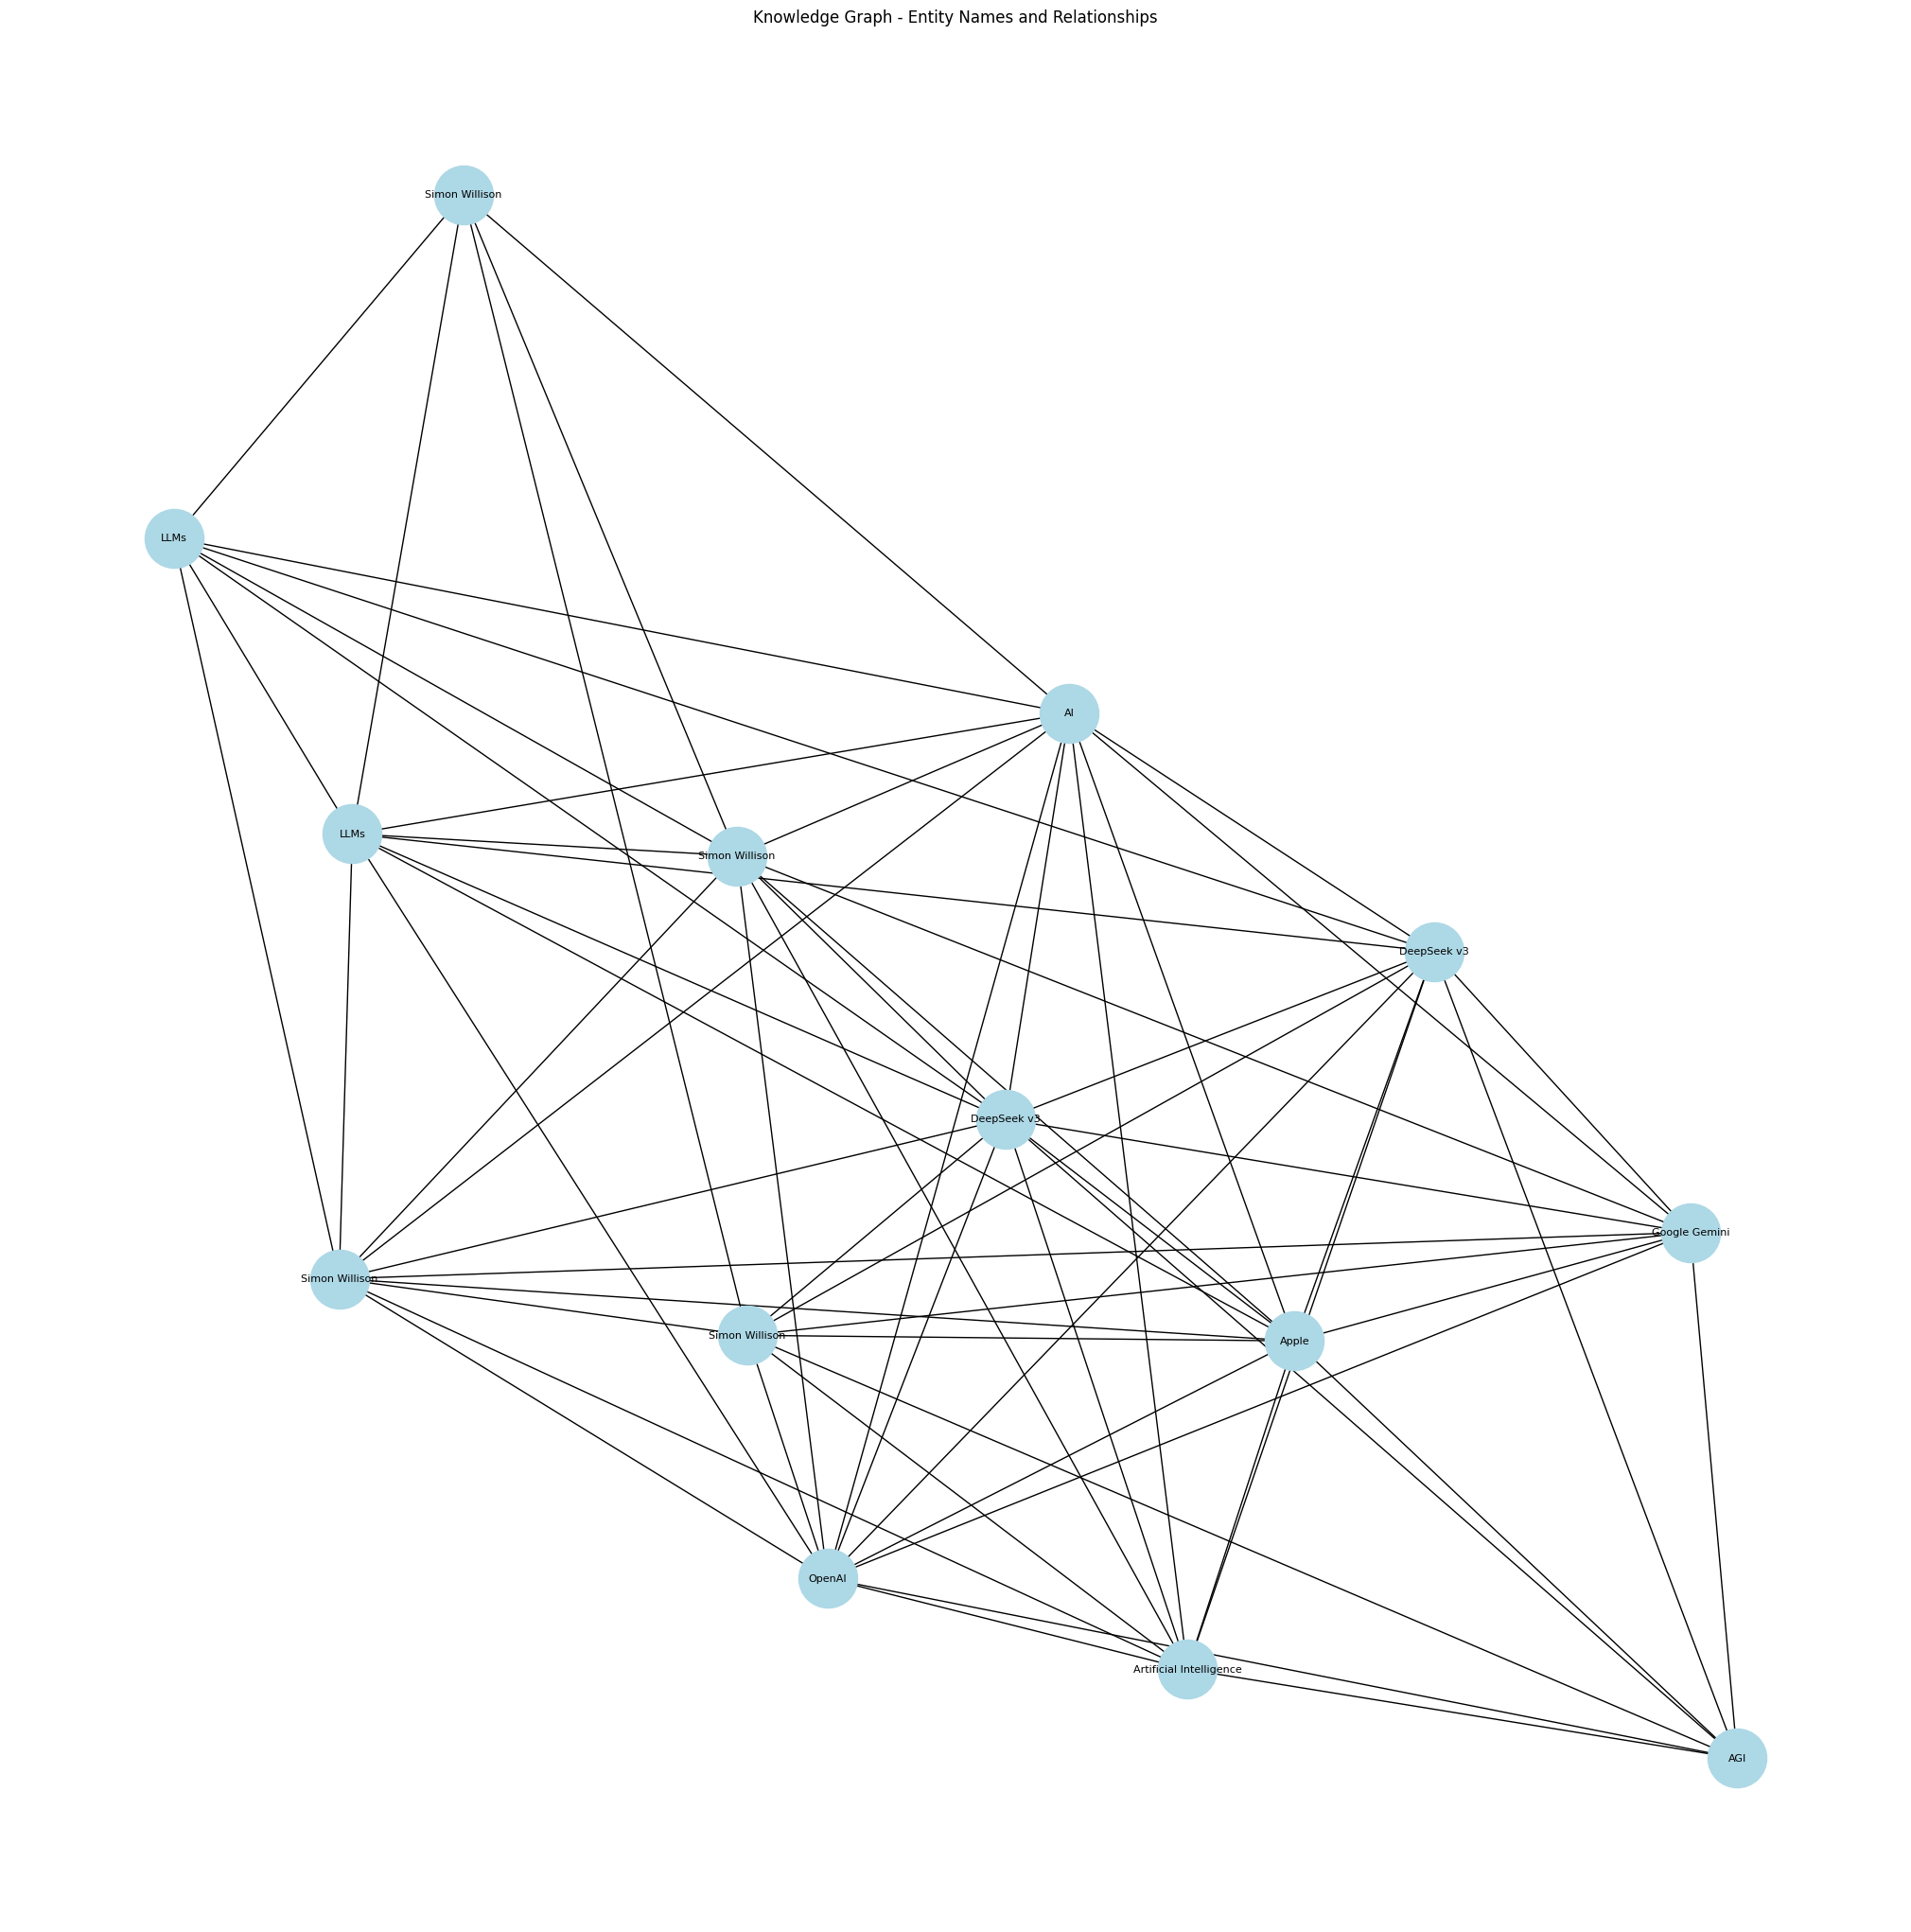

In [42]:
# Create a new visualization focusing on entity names and relationships
plt.figure(figsize=(20, 20))

# Create a new graph for visualization 
G = nx.Graph()

# Add nodes with just one entity name as label
for node in ai_across_years_kg.nodes:
    entities = node.properties.get('entities', [])
    if entities:
        # Just take the first entity as the label
        label = entities[0] if entities else ''
        G.add_node(node.id, label=label)

# Add edges from relationships
for rel in ai_across_years_kg.relationships:
    G.add_edge(rel.source.id, rel.target.id)

# Draw the graph
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw(G, pos,
        node_color='lightblue',
        node_size=2000,
        font_size=8,
        labels=nx.get_node_attributes(G, 'label'),
        with_labels=True)

plt.title("Knowledge Graph - Entity Names and Relationships")
plt.axis('off')
plt.show()



Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [14]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


Finally, we can use our `TestSetGenerator` to generate our testset!

In [ ]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [ ]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

In [ ]:
dataset.to_pandas()

We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [24]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [ ]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [34]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [35]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [36]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [37]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [53]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [54]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [55]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [56]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [ ]:
rag_chain.invoke({"question" : "What are Agents?"})

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [58]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [59]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

## LangSmith Evaluation

In [ ]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [61]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [62]:
rag_documents = docs

In [63]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

In [64]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

In [65]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [66]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [67]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [ ]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

Finally, we can evaluate the new chain on the same test set!

In [ ]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.